# Object Detection – YOLO v3

This notebook can be considered as an appendix to the file README.md, so you must read this last before getting started with this notebook.

This notebook provides some use cases of YOLO v3 using TensorFlow 2.2.0.rc3.

It is pretty much impossible to implement YOLO v3 from scratch, so I had to reference to the official repository to have some ideas about the implementation, but it was pretty hard to understand especially that it is not yet translated to TensorFlow. Then, I had to reference to many un-official repositories that had many minor errors that I corrected, and I improved either using the documentation of TensorFlow or some other repositories to do this notebook. One of the best repositories that I found and that helped a lot to understand the implementation of YOLO v3 are the following ones: [link 1](https://github.com/zzh8829/yolov3-tf2) and [link 2](https://github.com/AntonMu/TrainYourOwnYOLO). So, I want to give a big thanks to the authors of these two repositories for the great job they did. 

Before getting started, make sure to set up a virtual environment and install all of the dependencies by running the following command: pip install -r requirements.txt or pip3 install -r requirements.txt 

I recommend launching this notebook from the created virtual environment. 

For a sanity check, I investigate if everything has been successfully installed by running the following command: 

In [1]:
!pip install -r requirements.txt

Obtaining file:///c/Users/yfakihan/workspace/POC/POC1/YOLO/YOLO1/yolov3-tf2 (from -r requirements.txt (line 11))


  Attempting uninstall: yolov3-tf2
    Found existing installation: yolov3-tf2 0.1
    Uninstalling yolov3-tf2-0.1:
      Successfully uninstalled yolov3-tf2-0.1
  Running setup.py develop for yolov3-tf2


It is highly recommended to keep the original folder structure of this repository. This repository contains also a lot of images to play with either to train or to test the different models that we will create. 

## Image Annotation and Training Data

To train our detector to detect the different objects in an image, such as cat faces in this example, it needs to be fed with some labeled images which represent our training data.

To get acceptable results, this dataset contains 100 images for training and 30 images for validation.

As I explained in the attached document, it is recommended to use the Microsoft Visual Object Tagging Tool (VoTT) to create our data set and to export it under the Pascal VOC format.

Since in this example we have to detect cat faces, then we have one class per image, but we may have multiple bounding boxes representing the same class in the same image, for example: 

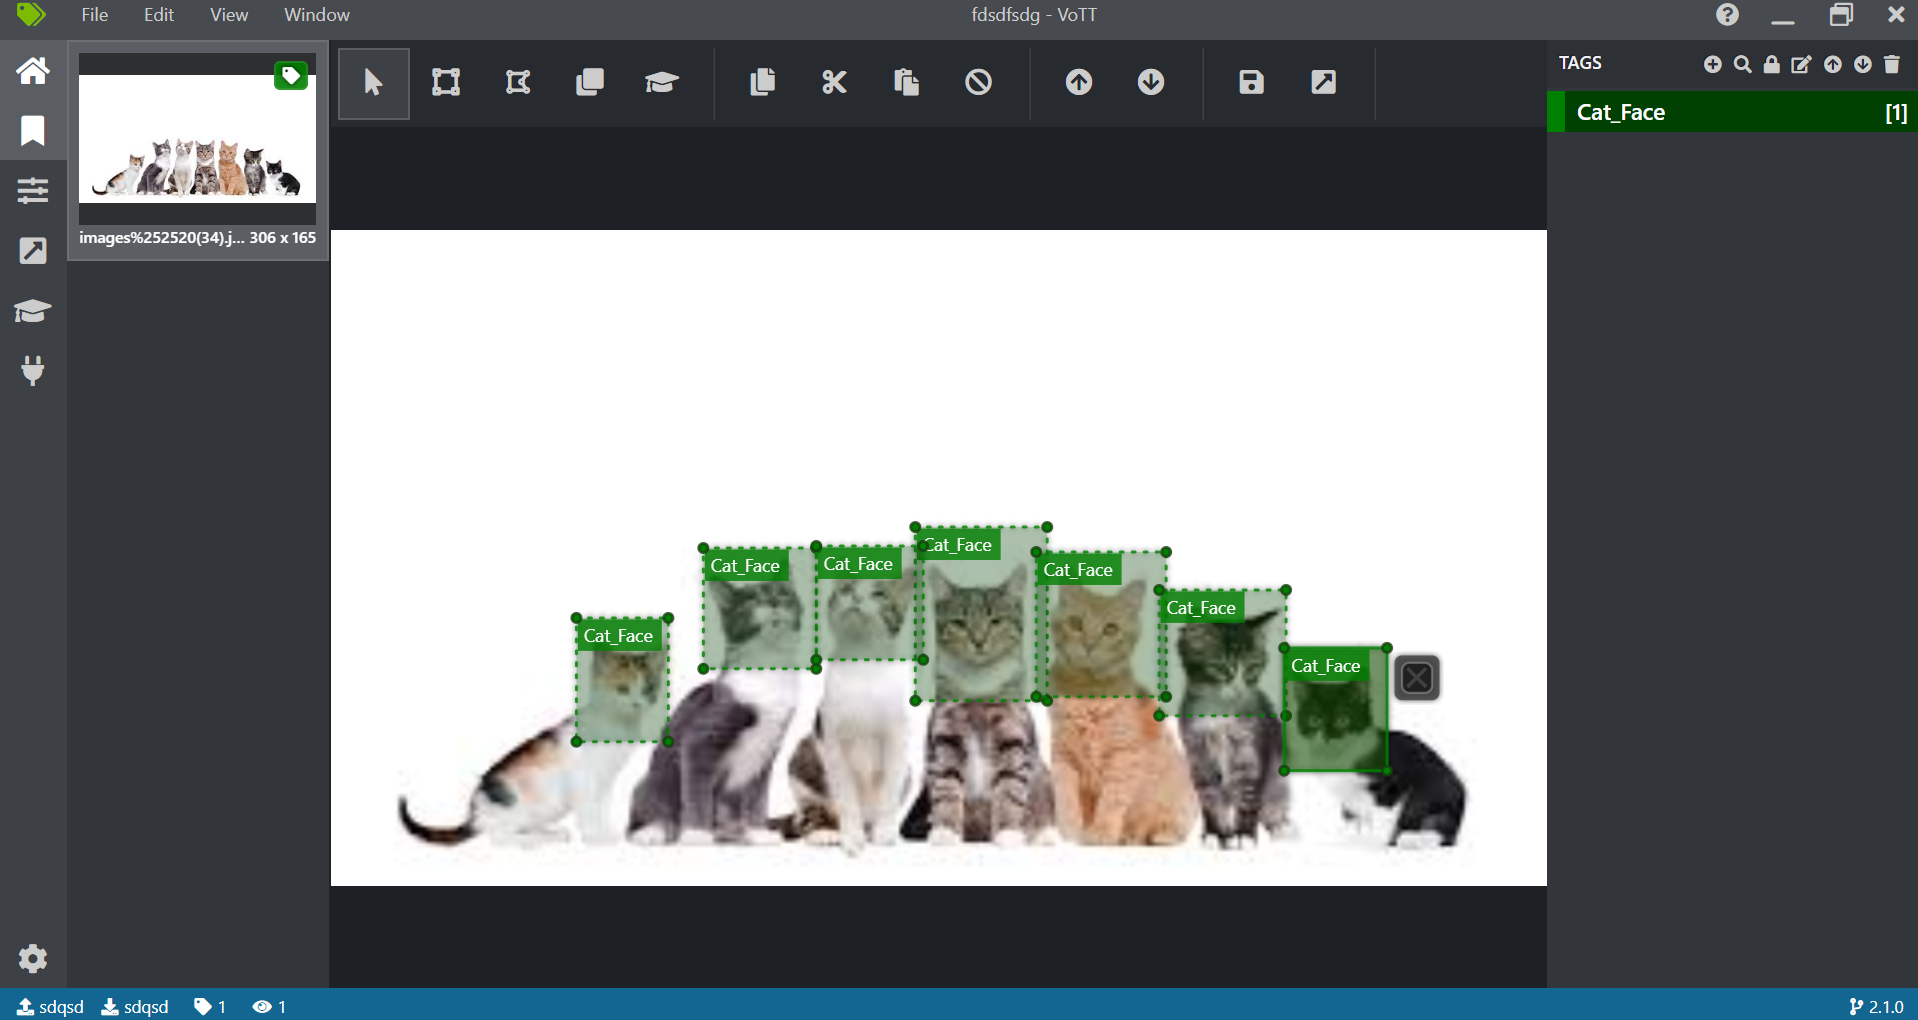

In [1]:
from IPython.display import Image
Image(filename='./data/multiple_bounding_boxes.png') 

To better train our model, it is of great importance to remember the maximum number of bounding boxes we put per image. For example, in this data set, it is equals to 7 (the image above) which means that the maximum number of bounding boxes in each image is less than or equal to 7.

Once we have finished labelling the images using Microsoft’s VoTT, we press CTRL + E  to export the project.

Since I already labeled the images, inside data/training_images/cat_images/export you should see a a folder called cat_data_set-PascalVOC-export. 

To enlarge the exported Pascal VOC data set using the imgaug library, I created the file augment.py where I made use of this library in order to create some new image based on two geometric transformations. 
To do that, let’s run the following command: 

In [2]:
!python augment.py

Next, we run this conversion script to convert the annotations from the enlarged Pascal VOC format to TFRecord format.

In [3]:
!python tools/voc_cat_face.py \
  --data_dir './data/training_images/cat_images/export/cat_faces--PascalVOC-export' \
  --split train \
  --classes './data/cat_face.names' \
  --output_file ./data/cat_face_train.tfrecord

I0430 14:24:03.093469 140349480109888 voc_cat_face.py:91] Class mapping loaded: {'Cat_Face': 0}
I0430 14:24:03.096933 140349480109888 voc_cat_face.py:96] Image list loaded: 510
100%|████████████████████████████████████████| 510/510 [00:01<00:00, 451.14it/s]
I0430 14:24:04.251466 140349480109888 voc_cat_face.py:107] Done


In [4]:
!python tools/voc_cat_face.py \
  --data_dir './data/training_images/cat_images/export/cat_faces--PascalVOC-export' \
  --split val \
  --classes './data/cat_face.names' \
  --output_file ./data/cat_face_val.tfrecord

I0430 14:24:10.220487 140519236896576 voc_cat_face.py:91] Class mapping loaded: {'Cat_Face': 0}
I0430 14:24:10.222692 140519236896576 voc_cat_face.py:96] Image list loaded: 43
100%|██████████████████████████████████████████| 43/43 [00:00<00:00, 474.73it/s]
I0430 14:24:10.341116 140519236896576 voc_cat_face.py:107] Done


As a result, inside the "data" folder we should now see two tfrecord files named cat_face_train.tfrecord and cat_face_val.tfrecord. The first one will be used to fit the different parameters of the model and the last one will provide an unbiased evaluation of the fitted model (after every epoch) while tuning the model’s hyperparameters.

Of course, having 170 images for training is not enough training data to train our network from scratch. Also, according to the documentation of YOLO, when we are using any human recognizable images, Darknet pre-training and Transfer Learning will greatly benefit the training process, and it is quite impossible to get good convergence by training the entire YOLO network all at once from random weights. So, to save the training time while getting better performance of our network, I am going to train my YOLO v3 model using Transfer Learning.

So, this step requires loading the pretrained Darknet weights and to convert these pre-trained weights to YOLO format. To do this, we run the following command:


In [7]:
!wget https://pjreddie.com/media/files/yolov3.weights -O data/yolov3.weights
!python convert.py

2020-04-30 14:32:37.827376: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2020-04-30 14:32:37.827553: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: UNKNOWN ERROR (303)
2020-04-30 14:32:37.827728: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LFR028575): /proc/driver/nvidia/version does not exist
2020-04-30 14:32:37.829531: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-04-30 14:32:37.843257: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2712000000 Hz
2020-04-30 14:32:37.844578: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f93b8000b20 initialized for platform Host (this does not guarantee that 

I0430 14:32:45.368077 140275126765376 utils.py:45] yolo_darknet/conv2d_43 bn
I0430 14:32:45.457913 140275126765376 utils.py:45] yolo_darknet/conv2d_44 bn
I0430 14:32:45.468015 140275126765376 utils.py:45] yolo_darknet/conv2d_45 bn
I0430 14:32:45.548707 140275126765376 utils.py:45] yolo_darknet/conv2d_46 bn
I0430 14:32:45.561768 140275126765376 utils.py:45] yolo_darknet/conv2d_47 bn
I0430 14:32:45.634147 140275126765376 utils.py:45] yolo_darknet/conv2d_48 bn
I0430 14:32:45.641623 140275126765376 utils.py:45] yolo_darknet/conv2d_49 bn
I0430 14:32:45.708971 140275126765376 utils.py:45] yolo_darknet/conv2d_50 bn
I0430 14:32:45.716164 140275126765376 utils.py:45] yolo_darknet/conv2d_51 bn
I0430 14:32:45.784347 140275126765376 utils.py:45] yolo_conv_0/conv2d_52 bn
I0430 14:32:45.790620 140275126765376 utils.py:45] yolo_conv_0/conv2d_53 bn
I0430 14:32:45.848544 140275126765376 utils.py:45] yolo_conv_0/conv2d_54 bn
I0430 14:32:45.854212 140275126765376 utils.py:45] yolo_conv_0/conv2d_55 bn
I04

Once finished loading and converting these pre-trained Darknet weights, it is time to train our detector. Since I have 170 images for training and I do not have a lot of resources, I choose the following configuration to train this model: batch_size = 2, steps_per_epoch=85 and the training was for 150 epochs.

This configuration is not the best configuration leading to the best performance we can have. To find one of the appropriate combination of parameters adapted to our use case, we have to make use of another library like Optuna which is an open source hyperparameter optimization framework to automate hyperparameter search.

Depending of your setup and the resources you have, this process can take a few minutes to a few hours. That’s why it is highly recommended to use a GPU to speed up the training.

In [8]:
!python train.py \
    --dataset ./data/cat_face_train.tfrecord \
    --val_dataset ./data/cat_face_val.tfrecord \
    --classes ./data/cat_face.names \
    --num_classes 1 \
    --mode fit --transfer darknet \
    --batch_size 2 \
    --steps_per_epoch 255 \
    --epochs 150 \
    --yolo_max_boxes 7 \
    --weights ./checkpoints/yolov3.tf \
    --weights_num_classes 80 

2020-04-30 14:33:06.873214: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2020-04-30 14:33:06.873407: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: UNKNOWN ERROR (303)
2020-04-30 14:33:06.873568: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LFR028575): /proc/driver/nvidia/version does not exist
2020-04-30 14:33:06.894576: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-04-30 14:33:06.906243: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2712000000 Hz
2020-04-30 14:33:06.907457: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f86e8000b20 initialized for platform Host (this does not guarantee that 

During training, weights in the neural network are updated so that the model performs better on the training data. However, there comes a point where the model begun to overfit on the training data and further improvements will result in lower generalization performance. That’s why we make use of Callbacks which are a set of functions to be applied at the end of every epoch in the training procedure in order to get a view on internal states and statistics of the model during training, and to save the trained model and the weights after every epoch. 

The Early Stopping is a Callback from TensorFlow 2.x (Keras API). This technique is used to terminate the training before overfitting occurs. It means that the validation loss will improve until some epoch. Then, Early Stopping stop the training to avoid overfitting.

In our case, the training has been stopped at the epoch 88, we have then an Early Stopping. This is due to the fact that the validation loss stops improving after 84 epochs. Past that point, we start overfitting.

After every epoch TensorFlow saves the trained model in the “checkpoints” folder. We know that the best model is the one saved at the end of the epoch 84, so there is no need to keep the others. Let’s remove them. 

In [72]:
### WARNING !!!!!!!! CHOOSE CAREFULLY THE VALUE OF THE VARIABLES best_epoch AND end_epoch !!!!! ###
best_epoch = 84
end_epoch = 88
my_list = list(range(1,best_epoch)) + list(range(best_epoch+1, end_epoch+1))
#print(my_list)

In [40]:
for i in my_list:
    file1 = "yolov3_train_{}.tf.index".format(i)
    os.remove("./checkpoints/{}".format(file1)) 
    file2 = "yolov3_train_{}.tf.data-00000-of-00001".format(i)
    os.remove("./checkpoints/{}".format(file2))

FileNotFoundError: [Errno 2] No such file or directory: './checkpoints/yolov3_train_1.tf.index'

This concludes the training step. Now, we are ready to test our detector in new images. Navigate to the file data/test_images/cat_images where I put many cat images to test the trained network.

Let’s try this network on an image of this folder:

In [46]:
!python detect.py \
    --classes ./data/cat_face.names \
    --num_classes 1 \
    --weights ./checkpoints/yolov3_train_84.tf \
    --output ./data/output.jpg \
    --image ./data/test_images/cat_images/5.jpg

2020-04-24 12:04:15.979587: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2020-04-24 12:04:15.979749: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: UNKNOWN ERROR (303)
2020-04-24 12:04:15.979918: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LFR028575): /proc/driver/nvidia/version does not exist
2020-04-24 12:04:15.997431: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-04-24 12:04:16.012729: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2712000000 Hz
2020-04-24 12:04:16.015279: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f98a8000b20 initialized for platform Host (this does not guarantee that 

The output image is saved under the name output.jpg on the “data” folder. To choose another location we change the “output” flag.

Let’s display the result of the execution:

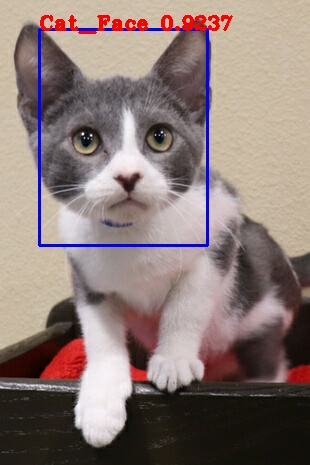

In [47]:
Image(filename='./data/output.jpg') 

In the output image we have a bounding box with the confidence score (quite high in this case) around the face of that cat. 

Let’s try another example: 

In [23]:
!python detect.py \
    --classes ./data/cat_face.names \
    --num_classes 1 \
    --weights ./checkpoints/yolov3_train_84.tf \
    --output ./data/output1.jpg \
    --image ./data/test_images/cat_images/10.jpeg

2020-04-29 16:25:27.886957: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2020-04-29 16:25:27.887117: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: UNKNOWN ERROR (303)
2020-04-29 16:25:27.887257: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LFR028575): /proc/driver/nvidia/version does not exist
2020-04-29 16:25:27.906481: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-04-29 16:25:27.923991: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2712000000 Hz
2020-04-29 16:25:27.925540: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f0fa0000b20 initialized for platform Host (this does not guarantee that 

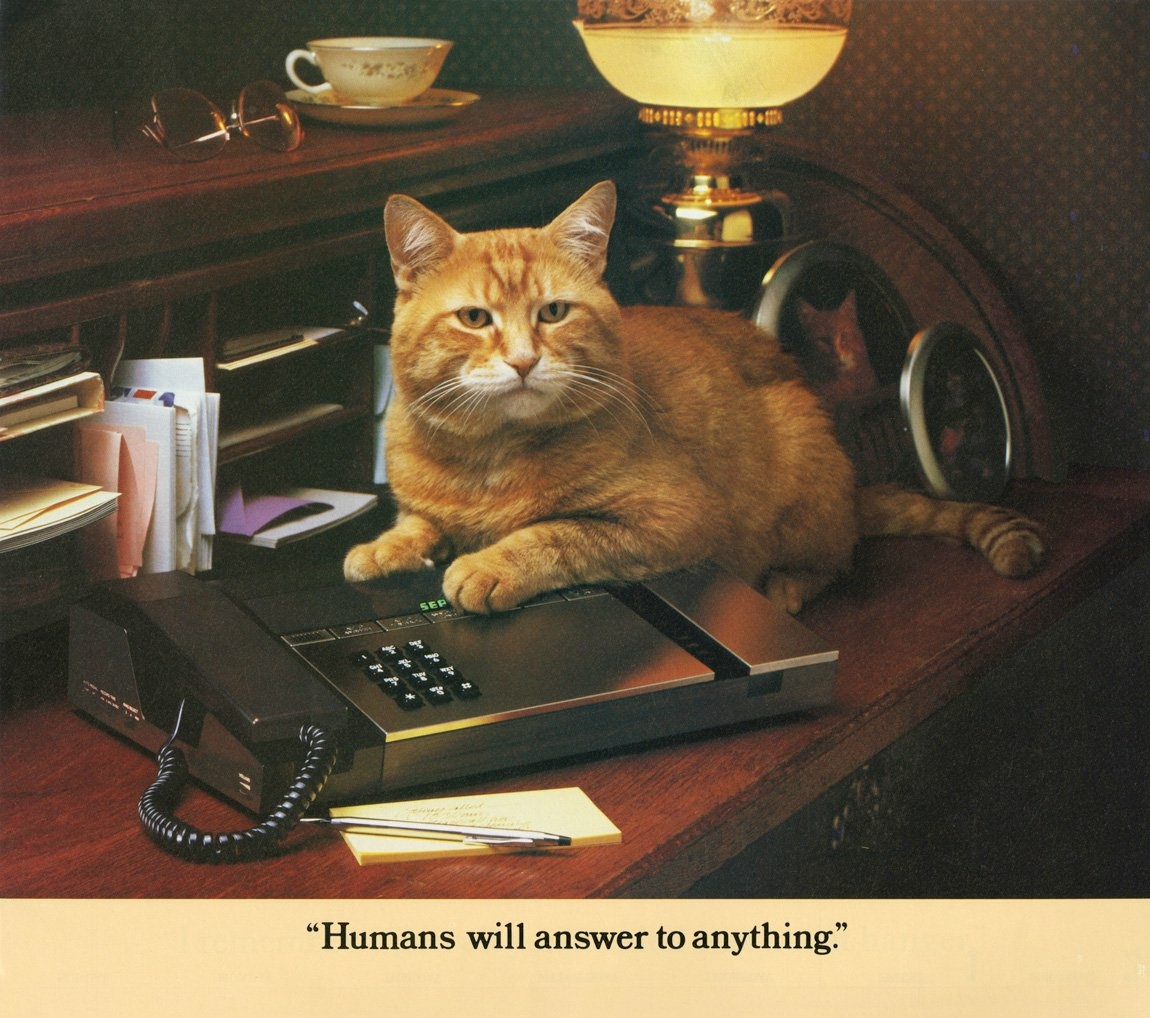

In [24]:
Image(filename='./data/output1.jpg') 

We do not have any prediction in this case!

Actually, the model predicted the bounding boxes on this image, but the confidence score of this prediction in this case is less than the value of the IOU and the Score thresholds, so no bounding box is printed on the output image. 

This is due to the fact that our model is not very well trained, either because of the lack of data and/or the value of the different parameters of this model which are not fine-tuned. 

As a result, we need a lower score threshold to have a printed box on this image.

Let’s try again, but this time with a lower IOU and Score thresholds.

In [25]:
!python detect.py \
    --classes ./data/cat_face.names \
    --num_classes 1 \
    --weights ./checkpoints/yolov3_train_84.tf \
    --output ./data/output2.jpg \
    --yolo_iou_threshold 0.1 \
    --yolo_score_threshold 0.1 \
    --image ./data/test_images/cat_images/10.jpeg

2020-04-29 16:26:08.198468: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2020-04-29 16:26:08.198697: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: UNKNOWN ERROR (303)
2020-04-29 16:26:08.198853: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LFR028575): /proc/driver/nvidia/version does not exist
2020-04-29 16:26:08.233528: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-04-29 16:26:08.256858: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2712000000 Hz
2020-04-29 16:26:08.258081: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fe428000b20 initialized for platform Host (this does not guarantee that 

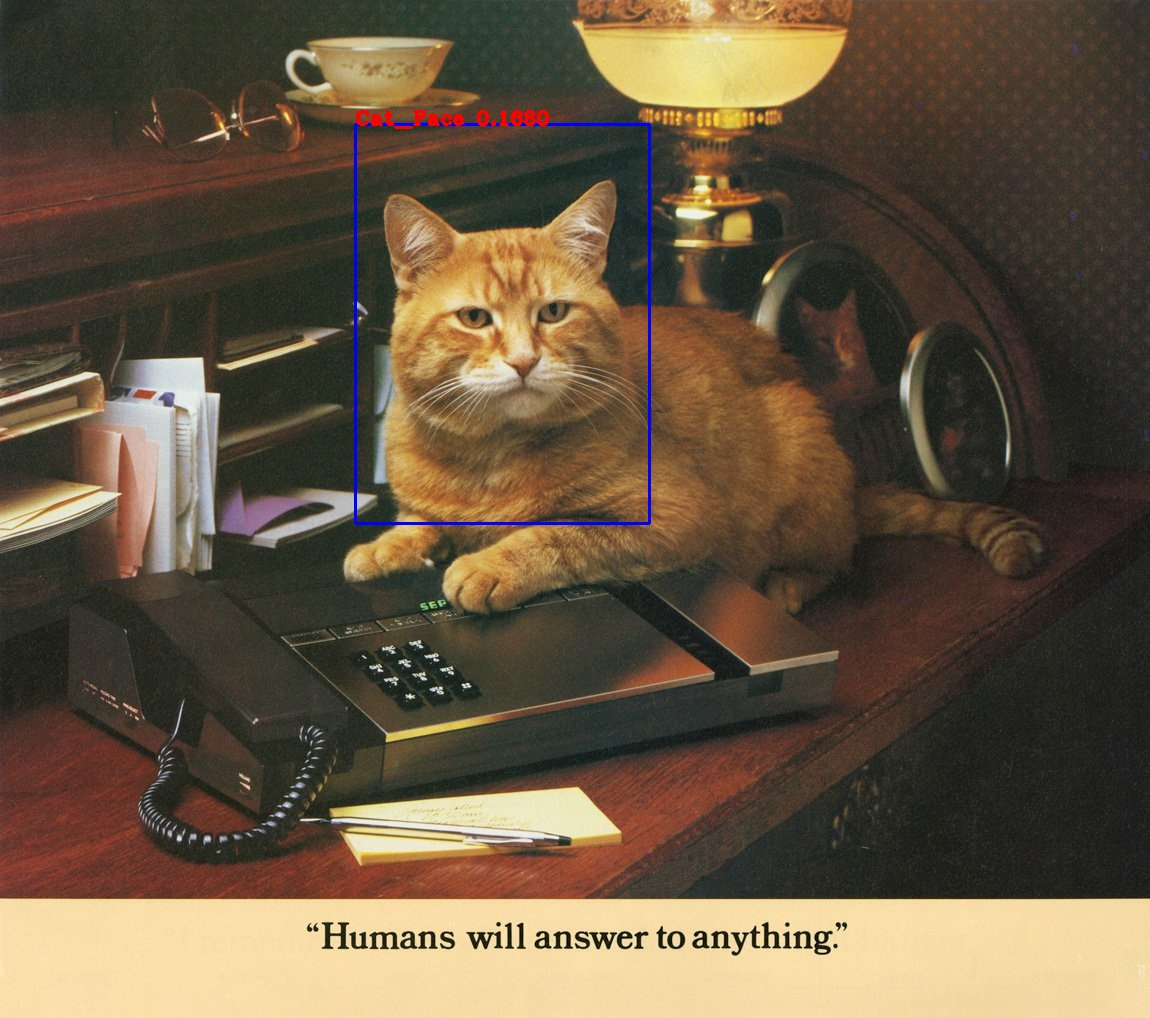

In [26]:
Image(filename='./data/output2.jpg') 

As expected, this time the predicted bounding box has been printed on the image, even if we do not have a good prediction and either a good confidence score.

Notice that, when we use very low thresholds, we may get many no desirable boxes on the output image. To illustrate this case , let’s try again the last example with a low value of the two thresholds.

In [27]:
!python detect.py \
    --classes ./data/cat_face.names \
    --num_classes 1 \
    --weights ./checkpoints/yolov3_train_84.tf \
    --output ./data/output3.jpg \
    --yolo_iou_threshold 0.00001 \
    --yolo_score_threshold 0.00001 \
    --image ./data/test_images/cat_images/10.jpeg

2020-04-29 16:26:43.423807: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2020-04-29 16:26:43.423987: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: UNKNOWN ERROR (303)
2020-04-29 16:26:43.424138: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LFR028575): /proc/driver/nvidia/version does not exist
2020-04-29 16:26:43.452623: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-04-29 16:26:43.472937: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2712000000 Hz
2020-04-29 16:26:43.474586: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fbdd8000b20 initialized for platform Host (this does not guarantee that 

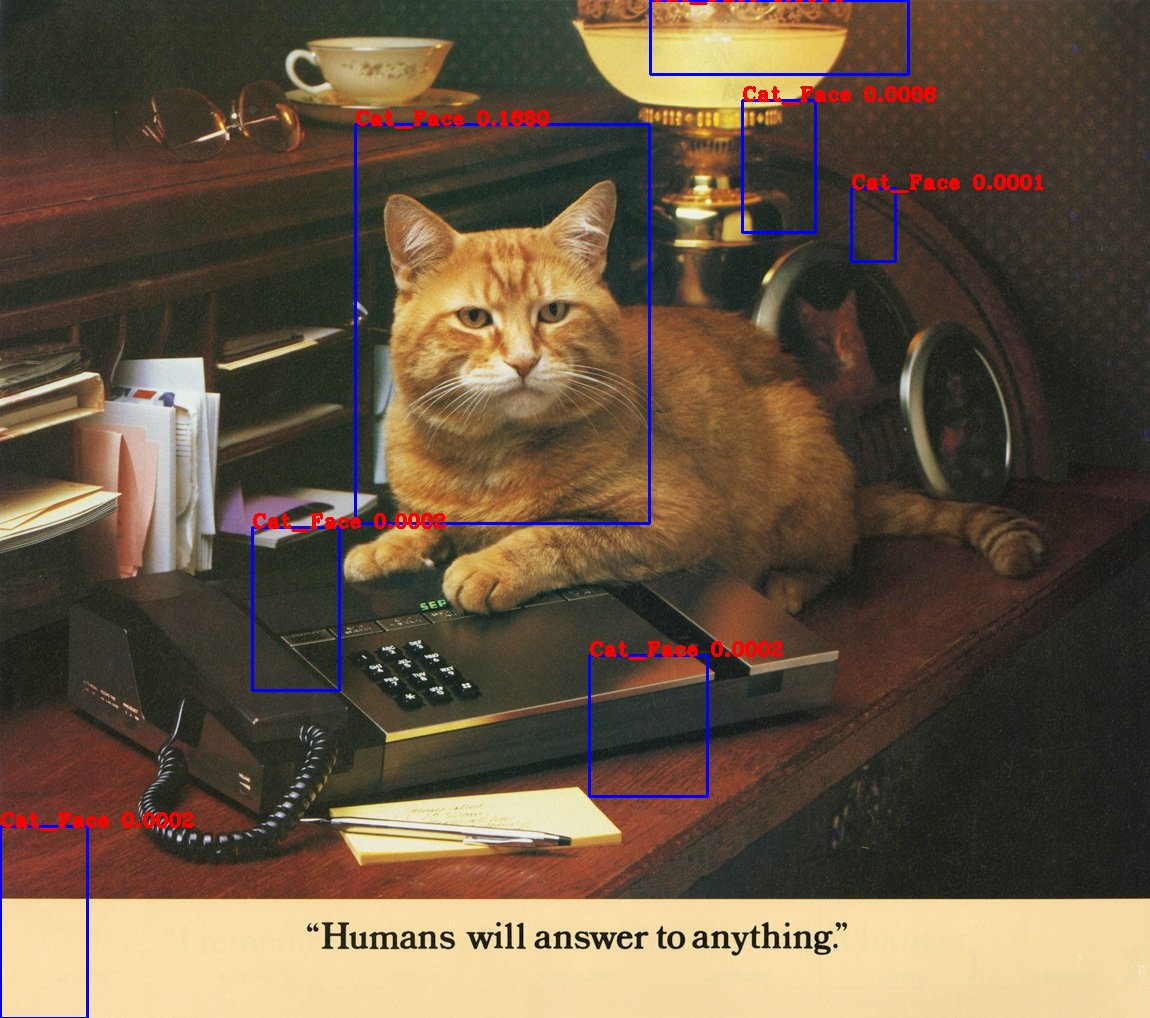

In [28]:
Image(filename='./data/output3.jpg') 

As excepted again, we get many irrelevant boxes. 

To bypass those kinds of situations, there is a trick that we can do: when we know that all the time our detector will face situations when it will have to predict only one box per image, we can add another flag while predicting. This latter is used in order to force the network to predict only one bounding box per image. 

Let's see how it works:

In [29]:
!python detect.py \
    --classes ./data/cat_face.names \
    --num_classes 1 \
    --weights ./checkpoints/yolov3_train_84.tf \
    --output ./data/output4.jpg \
    --yolo_iou_threshold 0.00001 \
    --yolo_score_threshold 0.00001 \
    --yolo_max_boxes 1 \
    --image ./data/test_images/cat_images/10.jpeg

2020-04-29 16:27:21.533533: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2020-04-29 16:27:21.533693: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: UNKNOWN ERROR (303)
2020-04-29 16:27:21.533874: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LFR028575): /proc/driver/nvidia/version does not exist
2020-04-29 16:27:21.551988: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-04-29 16:27:21.561324: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2712000000 Hz
2020-04-29 16:27:21.562370: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fc794000b20 initialized for platform Host (this does not guarantee that 

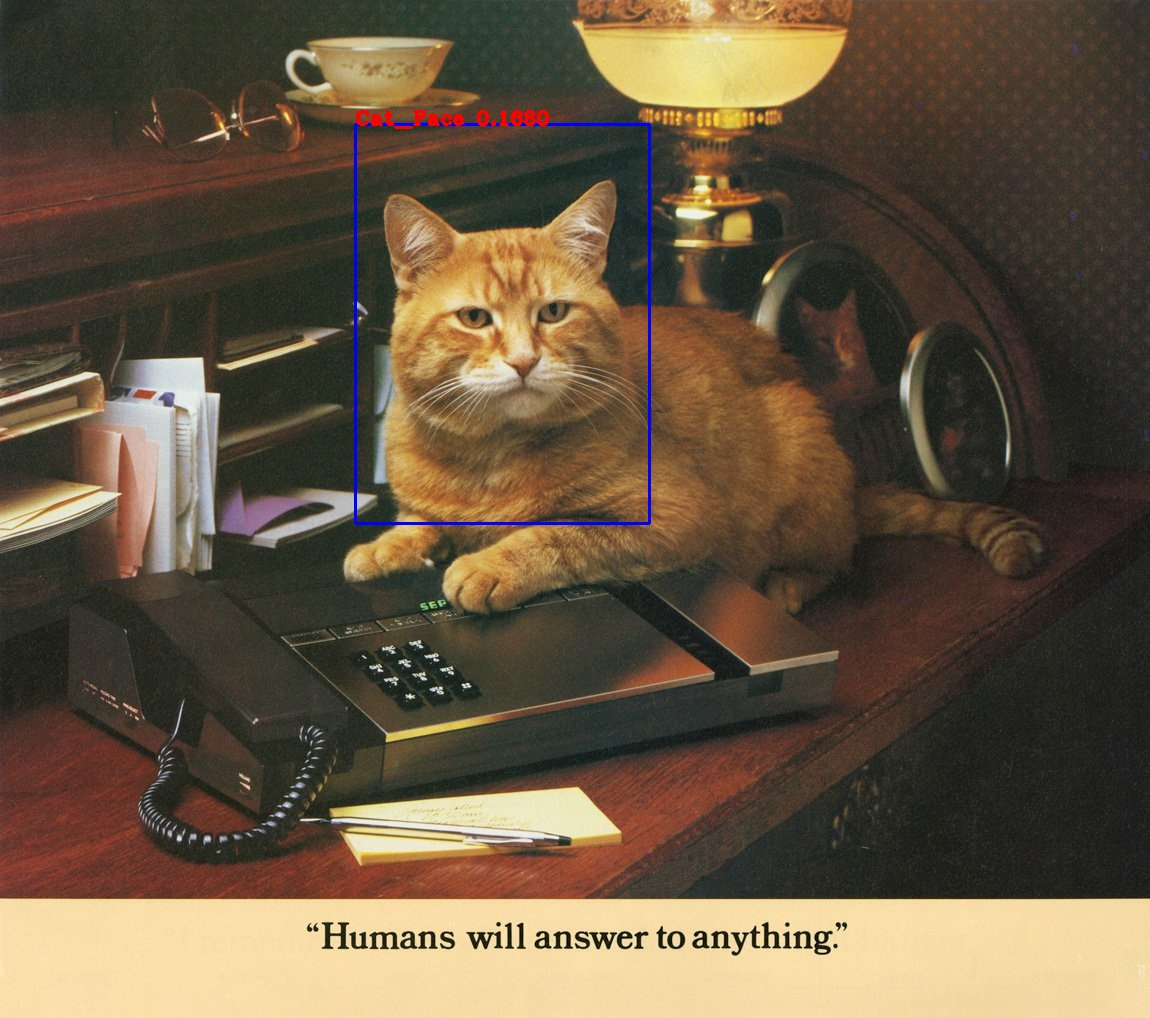

In [30]:
Image(filename='./data/output4.jpg') 